# Dementia (임상 치매 환자 판별 및 설문지 재구성)
 - <a href="Dementia.pptx"> 발표자료 </a>
 
### 치매를 보다 신속하게 진단/선별하는 방법을 모색한다
        << 현황 >> 
  - 총 117문항으로 이루어진 선별 검사의 긴 소요시간으로 인한 컴플레인 발생
    
        << 목표 >> 
  - 최소한의 소요시간과 최대한의 정확도로 치매 환자 예측 기법 발굴 ⇒ 최소화한 선별 검사로 선별력 향상도에 기여

<img src="1.PNG" width=700>
<img src="2.PNG" width=700>
<img src="3.PNG" width=700>
<img src="4.PNG" width=700>

- KDSQ:Korean Dementia Screen Questionnaire- 보호자용 설문지
- SIADL:Seoul Instrumental Activities of Daily Living- 도구적 일상생활능력평가지
- NPI:Neuropsychistric Inventory- 신경정신과적 증상 평가지
- MMSE:Meni-Mental State Examination- 환자용 평가지
- KGDS:Korean Geriatric Depression Scale- 한국형 노인우울증 평가지

In [18]:
library(psych) ; library(GPArotation) ; library(lattice) ; library(caret)
library(C50) ; library(ROCR) ; library(e1071) ; library(Epi) ; library(pROC)
library(ggplot2) ; library(scales) ; library(plyr) ; library(reshape2)
library(RColorBrewer) ; library(gridExtra)

In [28]:
NP_test <- read.csv("data/NP_test.csv", header = TRUE)
head(NP_test)

,id,Dx_str,Dx,Dx1,Dx2,Gender,Education,Age,Date,Smoking,...,MMSE_R,MMSE_Or_time,MMSE_Or_place,MMSE_regist,MMSE_att,MMSE_recall,MMSE_lang,KDSQ_mem,KDSQ_others,KDSQ_ADL
1,1,dementia,2,1,1,0,0,72,2006-03-29,0,...,12,4,4,3,0,0,7,4,6,2
2,2,dementia,2,1,1,0,6,68,2006-03-29,0,...,10,3,5,3,0,0,9,6,3,0
3,3,dementia,2,1,1,0,0,79,2006-04-21,0,...,12,3,2,3,0,3,7,8,6,4
4,4,dementia,2,1,1,0,6,73,2006-04-21,0,...,15,1,3,3,0,0,8,8,4,5
5,5,dementia,2,1,1,0,0,76,2006-05-02,0,...,22,0,1,2,0,0,5,9,6,8
6,6,dementia,2,1,1,0,9,79,2006-05-12,1,...,15,1,3,3,2,0,6,10,6,7


## 범주형 자료 변환 

#### 성별 

In [29]:
NP_test$Gender <- factor(NP_test$Gender, labels = c("Female", "Male")) #성별

#### 진단명 

In [30]:
NP_test$Dx <- factor(NP_test$Dx, labels = c("control", "MCI", "dementia")) #진단명 
NP_test$Dx1 <- factor(NP_test$Dx1, labels = c("control", "Cog dysfunc"))
NP_test$Dx2 <- factor(NP_test$Dx2, labels = c("control", "dementia"))

#### 기타 

In [31]:
NP_test$Smoking <- factor(NP_test$Smoking, labels = c("none", "current smoker")) #흡연
NP_test$FHx_dementia <- factor(NP_test$FHx_dementia, labels = c("none", "Family history of dementia")) # 치매 가족력
NP_test$Diabetes <- factor(NP_test$Diabetes, labels = c("none", "Diabetes mellitus")) #당뇨병
NP_test$HTN <- factor(NP_test$HTN, labels = c("none", "Hypertension")) # 고혈압
NP_test$Dyslipid <- factor(NP_test$Dyslipid, labels =c("none", "Dyslipidemia")) # 고지혈증
NP_test$Heart <- factor(NP_test$Heart, labels = c("none", "Heart disease")) # 심장병
NP_test$Stroke <- factor(NP_test$Stroke, labels = c("none", "Stroke")) # 뇌졸증

In [32]:
head(NP_test)

,id,Dx_str,Dx,Dx1,Dx2,Gender,Education,Age,Date,Smoking,...,MMSE_R,MMSE_Or_time,MMSE_Or_place,MMSE_regist,MMSE_att,MMSE_recall,MMSE_lang,KDSQ_mem,KDSQ_others,KDSQ_ADL
1,1,dementia,dementia,Cog dysfunc,dementia,Female,0,72,2006-03-29,none,...,12,4,4,3,0,0,7,4,6,2
2,2,dementia,dementia,Cog dysfunc,dementia,Female,6,68,2006-03-29,none,...,10,3,5,3,0,0,9,6,3,0
3,3,dementia,dementia,Cog dysfunc,dementia,Female,0,79,2006-04-21,none,...,12,3,2,3,0,3,7,8,6,4
4,4,dementia,dementia,Cog dysfunc,dementia,Female,6,73,2006-04-21,none,...,15,1,3,3,0,0,8,8,4,5
5,5,dementia,dementia,Cog dysfunc,dementia,Female,0,76,2006-05-02,none,...,22,0,1,2,0,0,5,9,6,8
6,6,dementia,dementia,Cog dysfunc,dementia,Female,9,79,2006-05-12,current smoker,...,15,1,3,3,2,0,6,10,6,7


In [33]:
str(NP_test)

'data.frame':	11902 obs. of  119 variables:
 $ id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Dx_str       : Factor w/ 3 levels "control","dementia",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Dx           : Factor w/ 3 levels "control","MCI",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Dx1          : Factor w/ 2 levels "control","Cog dysfunc": 2 2 2 2 2 2 2 2 2 2 ...
 $ Dx2          : Factor w/ 2 levels "control","dementia": 2 2 2 2 2 2 2 2 2 2 ...
 $ Gender       : Factor w/ 2 levels "Female","Male": 1 1 1 1 1 1 1 2 1 1 ...
 $ Education    : int  0 6 0 6 0 9 0 6 0 0 ...
 $ Age          : int  72 68 79 73 76 79 84 77 80 66 ...
 $ Date         : Factor w/ 1627 levels "2005-01-18","2005-02-28",..: 116 116 134 134 141 148 162 171 173 173 ...
 $ Smoking      : Factor w/ 2 levels "none","current smoker": 1 1 1 1 1 2 1 2 2 1 ...
 $ FHx_dementia : Factor w/ 2 levels "none","Family history of dementia": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diabetes     : Factor w/ 2 levels "none","Diabetes mellitus": 2 1 1 1 1 2 1 1 1 1 ...
 $ 

# 1-1 분석 대상의 인구학적 특징 

In [34]:
summary(NP_test[,c(3:8, 10:15)]) #진단명, 성별/교육/나이, 위험인자 분포 

        Dx                Dx1              Dx2          Gender    
 control :1291   control    : 1291   control :1291   Female:7910  
 MCI     :4145   Cog dysfunc:10611   dementia:6466   Male  :3992  
 dementia:6466                       NA's    :4145                
                                                                  
                                                                  
                                                                  
   Education           Age                  Smoking     
 Min.   : 0.000   Min.   :50.00   none          :10972  
 1st Qu.: 3.000   1st Qu.:67.00   current smoker:  930  
 Median : 6.000   Median :73.00                         
 Mean   : 7.266   Mean   :72.25                         
 3rd Qu.:12.000   3rd Qu.:78.00                         
 Max.   :25.000   Max.   :96.00                         
                     FHx_dementia               Diabetes              HTN      
 none                      :9705   none             

In [65]:
Tmp_Graph <- NP_test[,c(3:8, 10:16)]

In [68]:
g1 <- ggplot(Tmp_Graph, aes(x=Dx1)) + geom_bar()
g2 <- ggplot(Tmp_Graph, aes(x=Dx2)) + geom_bar()
g3 <- ggplot(Tmp_Graph, aes(x=Gender)) + geom_bar()
g4 <- ggplot(Tmp_Graph, aes(x="Education", y=Education))+geom_boxplot()
g5 <- ggplot(Tmp_Graph, aes(x="Age", y = Age)) + geom_boxplot()
g6 <- ggplot(Tmp_Graph, aes(x=FHx_dementia)) + geom_bar()
g7 <- ggplot(Tmp_Graph, aes(x=Diabetes)) + geom_bar()
g8 <- ggplot(Tmp_Graph, aes(x=HTN)) + geom_bar()
g9 <- ggplot(Tmp_Graph, aes(x=Dyslipid)) + geom_bar()
g10 <- ggplot(Tmp_Graph, aes(x=Heart)) + geom_bar()
g11 <- ggplot(Tmp_Graph, aes(x=Stroke)) + geom_bar()

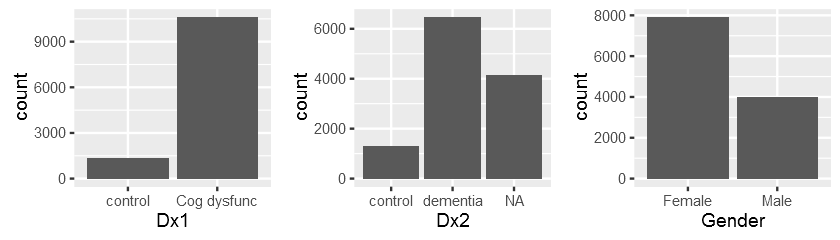

In [69]:
options(repr.plot.height=2)
grid.arrange( g1, g2, g3, nrow=1)

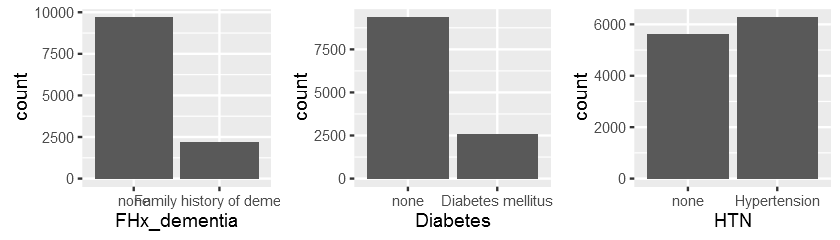

In [70]:
grid.arrange( g6, g7, g8, nrow=1)

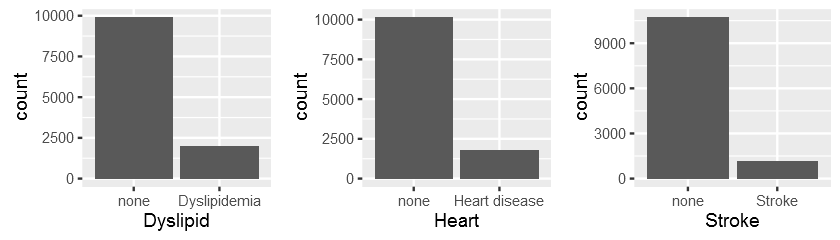

In [71]:
grid.arrange( g9, g10, g11, nrow=1)

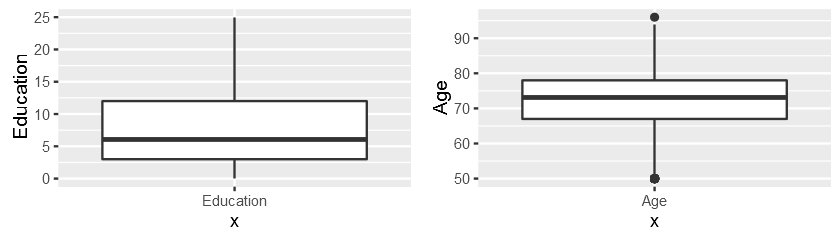

In [72]:
grid.arrange( g4, g5, nrow=1)

# 1-2 주요 인지기능검사 분포 

In [42]:
summary(NP_test[,c(89,106:109)]) #MMSE[,89], MMSE-R[,110]

      MMSE         KDSQ_total  SIADL_total      NPI_total        KGDS_total    
 Min.   : 0.00   Min.   : 0   Min.   : 0.00   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:17.00   1st Qu.: 5   1st Qu.: 2.00   1st Qu.: 1.000   1st Qu.: 3.000  
 Median :22.00   Median : 9   Median : 7.00   Median : 2.000   Median : 6.000  
 Mean   :21.36   Mean   :11   Mean   :11.15   Mean   : 3.047   Mean   : 6.495  
 3rd Qu.:26.00   3rd Qu.:16   3rd Qu.:17.00   3rd Qu.: 5.000   3rd Qu.:10.000  
 Max.   :30.00   Max.   :30   Max.   :45.00   Max.   :24.000   Max.   :15.000  

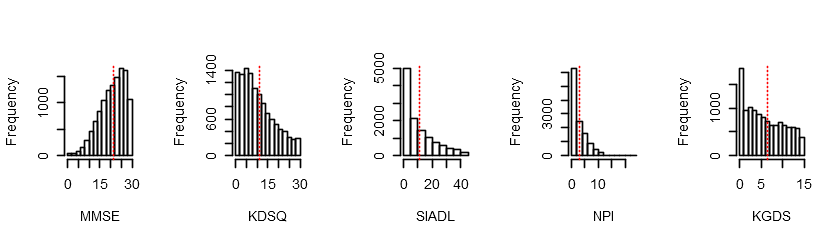

In [43]:
par(mfrow = c(1, 5))
hist(NP_test[,89], main="", xlab="MMSE")
abline(v=mean(NP_test[,89]), lty=3, col="red")
hist(NP_test[,106], main="", xlab="KDSQ")
abline(v=mean(NP_test[,106]), lty=3, col="red")
hist(NP_test[,107], main="", xlab="SIADL")
abline(v=mean(NP_test[,107]), lty=3, col="red")
hist(NP_test[,108], main="", xlab="NPI")
abline(v=mean(NP_test[,108]), lty=3, col="red")
hist(NP_test[,109], main="", xlab="KGDS")
abline(v=mean(NP_test[,109]), lty=3, col="red")

# 1-3 진단명에 따른 Histogram

In [47]:
options(repr.plot.height=3)

### 1. MMSE with DX (Mini-Mental State Examination, 환자용 검사지, 0~30점)
 - 치매환자가 평균적으로 낮은 점수를 가지는 성향이 있다.

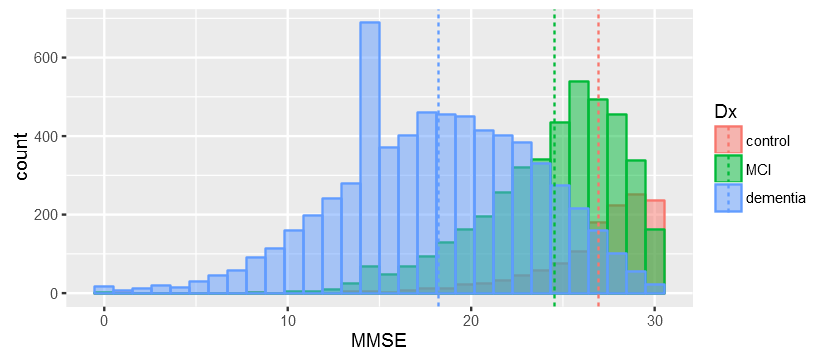

In [50]:
mmse.mu <- ddply(NP_test[,c(3,89)], "Dx", summarise, grp.mean=mean(MMSE))
p <- ggplot(NP_test[,c(3,89)], aes(x=MMSE, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 30)
p+geom_vline(data=mmse.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 2.KDSQ with DX (보호자용 설문지, 0~30점)
 - 치매환자가 평균적으로 높은 성향이 있다.

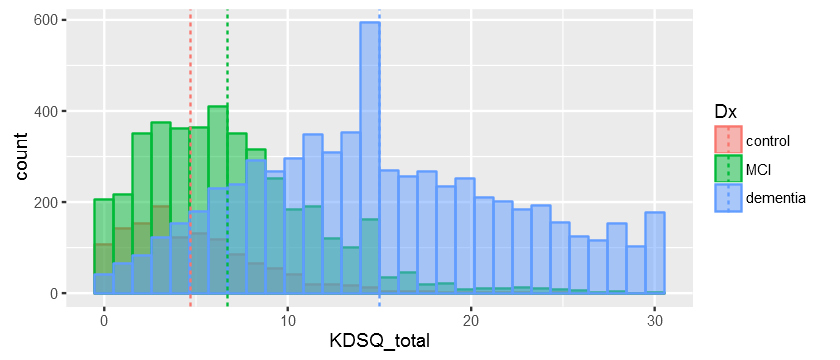

In [51]:
kdsq.mu <- ddply(NP_test[,c(3,106)], "Dx", summarise, grp.mean=mean(KDSQ_total))
p <- ggplot(NP_test[,c(3,106)], aes(x=KDSQ_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 30)
p+geom_vline(data=kdsq.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 3. SIADL with DX (일상생활능력, 0~45점)
 - 치매환자가 평균적으로 높은 성향이 있다.

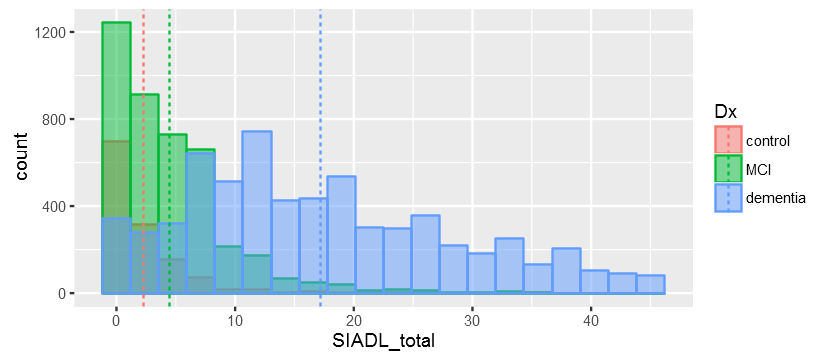

In [52]:
siadl.mu <- ddply(NP_test[,c(3,107)], "Dx", summarise, grp.mean=mean(SIADL_total))
p <- ggplot(NP_test[,c(3,107)], aes(x=SIADL_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 20)
p+geom_vline(data=siadl.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 4. NPI with DX (정신증상평가, 0~24점)
 - 크게 변별력 있지는 않을 듯 하다.

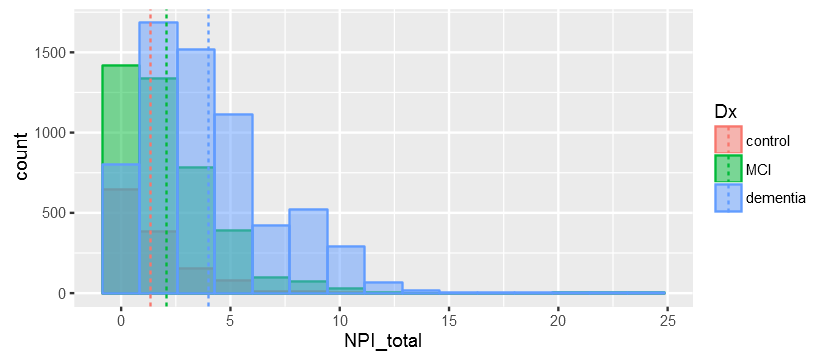

In [53]:
npi.mu <- ddply(NP_test[,c(3,108)], "Dx", summarise, grp.mean=mean(NPI_total))
p <- ggplot(NP_test[,c(3,108)], aes(x=NPI_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 15)
p+geom_vline(data=npi.mu,aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

### 5.KGDS with DX (한국형노인우울, 0~15점)
 - 크게 변별력 있지는 않다.

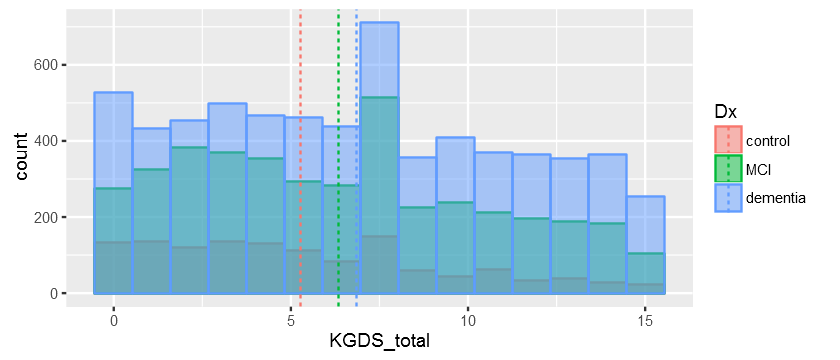

In [54]:
kgds.mu <- ddply(NP_test[,c(3,109)], "Dx", summarise, grp.mean=mean(KGDS_total))
p <- ggplot(NP_test[,c(3,109)], aes(x=KGDS_total, fill=Dx, color=Dx)) +
  geom_histogram(position="identity", alpha=0.5, bins = 15)
p+geom_vline(data=kgds.mu, aes(xintercept=grp.mean, color=Dx),
             linetype="dashed")

# 2-1. 진단명에 따른 의학적 분석 

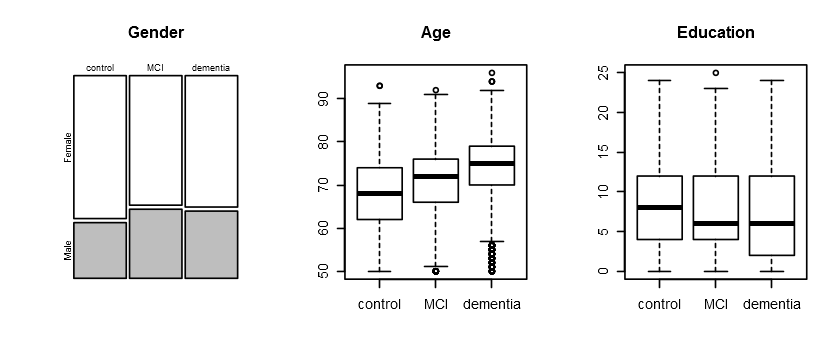

In [59]:
par(mfrow = c(1, 3))
plot(prop.table(table(NP_test$Dx, NP_test$Gender),1), type="h", col=c("white", "grey"),
     main="Gender")
#나이
boxplot(Age~Dx, data=NP_test, main="Age")

#학력
boxplot(Education~Dx, data=NP_test, main="Education")

#### 성별 

In [73]:
chisq.test(table(NP_test$Gender, NP_test$Dx))


	Pearson's Chi-squared test

data:  table(NP_test$Gender, NP_test$Dx)
X-squared = 20.677, df = 2, p-value = 3.237e-05


#### 나이 

In [74]:
out=aov(Age~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2  55963   27982   489.3 <2e-16 ***
Residuals   11899 680512      57                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Age ~ Dx, data = NP_test)

$Dx
                     diff      lwr      upr p adj
MCI-control      3.199281 2.634300 3.764261     0
dementia-control 6.381330 5.840968 6.921693     0
dementia-MCI     3.182050 2.829340 3.534759     0


#### 학력 

In [75]:
out=aov(Education~Dx, data=NP_test)
summary(out)
TukeyHSD(out)

               Df Sum Sq Mean Sq F value Pr(>F)    
Dx              2   2759  1379.7    50.1 <2e-16 ***
Residuals   11899 327692    27.5                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Education ~ Dx, data = NP_test)

$Dx
                       diff       lwr        upr     p adj
MCI-control      -0.5105278 -0.902584 -0.1184716 0.0064387
dementia-control -1.3098831 -1.684856 -0.9349102 0.0000000
dementia-MCI     -0.7993553 -1.044111 -0.5546000 0.0000000


# 2-2. 진단명에 따른 의학적 분석 2

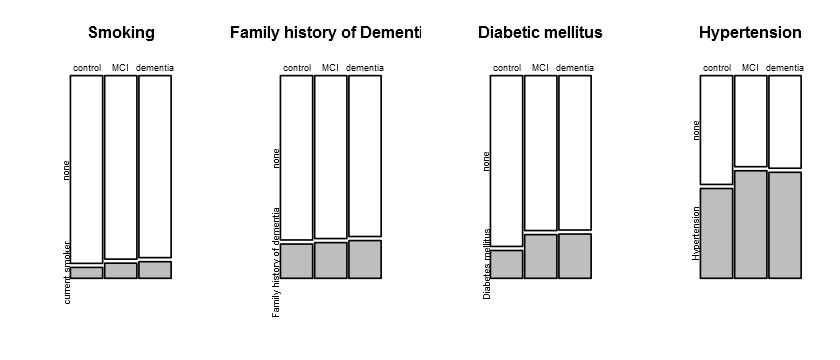

In [95]:
options(repr.plot.height=3)
par(mfrow = c(1, 4))
plot(prop.table(table(NP_test$Dx, NP_test$Smoking),1), type="h", col=c("white", "grey"),
     main="Smoking")
plot(prop.table(table(NP_test$Dx, NP_test$FHx_dementia),1), type="h", col=c("white", "grey"),
     main="Family history of Dementia")
plot(prop.table(table(NP_test$Dx, NP_test$Diabetes),1), type="h", col=c("white", "grey"),
     main="Diabetic mellitus")
plot(prop.table(table(NP_test$Dx, NP_test$HTN),1), type="h", col=c("white", "grey"),
     main="Hypertension")

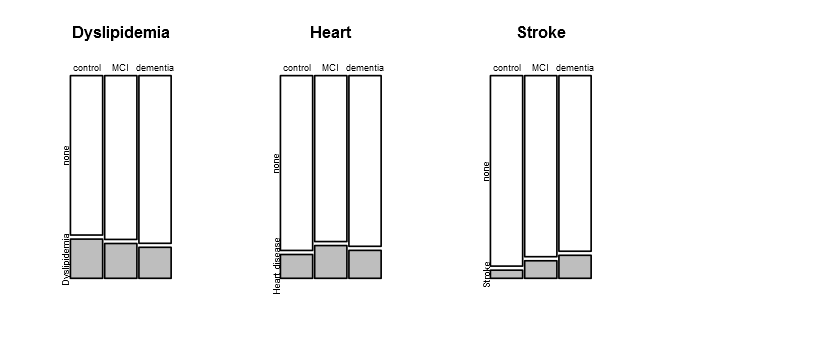

In [96]:
par(mfrow = c(1, 4))
plot(prop.table(table(NP_test$Dx, NP_test$Dyslipid),1), type="h", col=c("white", "grey"),
     main="Dyslipidemia")
plot(prop.table(table(NP_test$Dx, NP_test$Heart),1), type="h", col=c("white", "grey"),
     main="Heart")
plot(prop.table(table(NP_test$Dx, NP_test$Stroke),1), type="h", col=c("white", "grey"),
     main="Stroke")

In [97]:
chisq.test(table(NP_test$Smoking, NP_test$Dx))
chisq.test(table(NP_test$FHx_dementia, NP_test$Dx))
chisq.test(table(NP_test$Diabetes, NP_test$Dx))
chisq.test(table(NP_test$HTN, NP_test$Dx))
chisq.test(table(NP_test$Dyslipid, NP_test$Dx))
chisq.test(table(NP_test$Heart, NP_test$Dx))
chisq.test(table(NP_test$Stroke, NP_test$Dx))


	Pearson's Chi-squared test

data:  table(NP_test$Smoking, NP_test$Dx)
X-squared = 12.658, df = 2, p-value = 0.001784



	Pearson's Chi-squared test

data:  table(NP_test$FHx_dementia, NP_test$Dx)
X-squared = 3.1454, df = 2, p-value = 0.2075



	Pearson's Chi-squared test

data:  table(NP_test$Diabetes, NP_test$Dx)
X-squared = 45.798, df = 2, p-value = 1.136e-10



	Pearson's Chi-squared test

data:  table(NP_test$HTN, NP_test$Dx)
X-squared = 33.559, df = 2, p-value = 5.162e-08



	Pearson's Chi-squared test

data:  table(NP_test$Dyslipid, NP_test$Dx)
X-squared = 16.291, df = 2, p-value = 0.0002901



	Pearson's Chi-squared test

data:  table(NP_test$Heart, NP_test$Dx)
X-squared = 19.848, df = 2, p-value = 4.9e-05



	Pearson's Chi-squared test

data:  table(NP_test$Stroke, NP_test$Dx)
X-squared = 75.016, df = 2, p-value < 2.2e-16
